# Capstone Project - The Battle of Neighborhoods (London)

## Topic: Finding the best place to open a new restaurant in London

### 1- Introduction
#### 1-1- Background

London is the capital and largest city of the United Kingdom. The city stands on the River Thames in the south-east of England. The restaurant and leisure industry in London is growing exponentially, every street is filled with every variety of restaurant, fast food place, pub, bar, etc; every type of food is available from the classic European cuisines, primarily Italian and French, to more exotic foods originating from Asia or South America. The demand in the culinary industry, has become very high, and as a result, has the extent of competition, in order to open a restaurant in a trendy area of this city, like the Shoreditch area.

#### 1-2- Business Problem
Owning and running your own restaurant business is many people’s dream; at the same time, restaurants are a difficult business to own or operate. Many factors will contribute to where you decide your premises to be. It can be challenging to find a venue that will factor in all of your conditions, so you will likely have to compromise on a few things. However, the primary factor that you should consider is to find an appropriate location for this new restaurant and, as well as to be aware of the possible nearby and local competitors.

In this work, we will implement the fundamental analysis, in order to find the optimal London Borough, in which the restaurant can be opened. This is conducted according to the criteria. That there are many additional factors regarding this, but the analysis can be done after choosing the Borough, and thus will not be done within the scope of this project.

#### 1-3- Interest

The target audience of this work would be anyone with an interest to get involved in the leisure and restaurant business and industry within the London districts.



### 2- Data
#### 2-1- Data Description

To find a solution to the problem, and to be able to build a recommender model, first we consider the following:

* Its geographical coordinates (i.e., latitude and longitude) to find out where exactly the venues are located.

and

* In order to access the location of a restaurant, its latitude and longitude should be known, so that we can point to its coordinates, and further create a map displaying all the restaurants with its labels, respectively.

#### 2-2- Data Collection

   Based on the criteria listed above, the following data can be utilized in this analysis:
1.	The deployment of *BeautifulSoup*, in order to extract the data from Wikipedia, and to further provide the relevant information on the [London boroughs](https://en.wikipedia.org/wiki/London_boroughs), i.e., also known as the local authority districts. Besides, the [local areas or neighbourhoods](https://en.wikipedia.org/wiki/List_of_areas_of_London) are considered for each borough for the detailed analysis.
2.	The [Foursquare](https://foursquare.com/) API, in order to extract the relevant information on the available restaurants, for a given neighborhood and borough in London. This API also provided information about the restaurant styles based on cuisine.
3.	The utilized data provided by the UK Government available at [data.london.gov.uk](https://data.london.gov.uk/dataset/london-borough-profiles) to get detailed insights on the London boroughs.


### 3- Methodology


#### Installing and Importing Python Libraries and Dependencies

In [4]:
!conda install -c conda-forge folium

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2020.6.20          |   py36h9f0ad1d_0         151 KB  conda-forge
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    branca-0.4.1               |             py_0          26 KB  conda-forge
    openssl-1.1.1g             |       h516909a_1         2.1 MB  conda-forge
    folium-0.11.0              |             py_0          61 KB  conda-forge
    ca-certificates-2020.6.20  |       hecda079_0         145 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.5 MB

The following NEW packages will be INSTALLED:

    branca:          0.4.1-py_0        conda-forge
    folium:          

In [5]:
from bs4 import BeautifulSoup
import requests
import numpy as np
import pandas as pd

# !conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

import folium # map rendering library

from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans


import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.cm as cm
import matplotlib.colors as colors

### Data Extraction and Cleaning¶

##### Utilizing BeautifulSoup in order to scraping list of postal codes of given wikipedia page. Link: https://en.wikipedia.org/wiki/List_of_areas_of_London


In [6]:
source = requests.get('https://en.wikipedia.org/wiki/List_of_areas_of_London').text

soup = BeautifulSoup(source,'lxml')
My_Table = soup.find('table',{'class':'wikitable sortable'})

# First two columns
headers = My_Table.find_all('th')
headers = [th.text.strip() for th in headers]
headers = headers[:2]
x = headers[1].split('\xa0')
x = ' '.join(x)
headers.pop()
headers.append(x)
headers

['Location', 'London borough']

In [10]:
rows = []
for tr in My_Table.find_all('tr'):
    tds = tr.find_all('td')
    rows.append(tds)
    if not tds:
        continue
del rows[0]

col_0 = []
for i in range(len(rows)):
    col_0.append(rows[i][0])
Locations = []
for location in col_0:
    Locations.append(location.text)
for index, ele in enumerate(Locations):
    if '(' in ele:
        Locations[index] = Locations[index].split('(')[0]
for index, ele in enumerate(Locations):
    if ',' in ele:
        Locations[index] = Locations[index].split(',')[0]        
    
col_1 = []
for i in range(len(rows)):
    col_1.append(rows[i][1])
Boroughs = []
for borough in col_1:
    Boroughs.append(borough.text)
for index, ele in enumerate(Boroughs):
    if '[' in ele:
        Boroughs[index] = Boroughs[index].split('[')[0]
for index, ele in enumerate(Boroughs):
    if ',' in ele:
        Boroughs[index] = Boroughs[index].split(',')[0]

In [11]:
len(Locations)

533

##### Now it is time to convert the headers into latitude and longitude values:

In [14]:
headers.append('Latitude')
headers.append('Longitude')
if len(headers)>4:
    headers = headers[:4]

df = pd.DataFrame(list(zip(Locations, Boroughs, latitude, longitude)), 
               columns = headers) 
df.head()

,Location,London borough,Latitude,Longitude
0,Abbey Wood,Bexley,51.49,0.132891
1,Acton,Ealing,51.5081,-0.273261
2,Addington,Croydon,51.3586,-0.0316347
3,Addiscombe,Croydon,51.3797,-0.0742821
4,Albany Park,Bexley,51.4354,0.125965


In [15]:
#Delete rows with locations not having latitude and longitude values
df = df[df.Latitude != "Not Found"]
df.shape

(180, 4)

In [16]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(df['London borough'].unique()),
        df.shape[0]
    )
)

The dataframe has 34 boroughs and 180 neighborhoods.


In [17]:
address = 'London, England'

geolocator = Nominatim(user_agent="london_explorer")
location = geolocator.geocode(address)
lat_e = location.latitude
long_e = location.longitude
print('The geograpical coordinate of London City are {}, {}.'.format(lat_e, long_e))

The geograpical coordinate of London City are 51.5073219, -0.1276474.


#### Map of London 

In [18]:
# create map of London using latitude and longitude values
map_london = folium.Map(location=[lat_e, long_e], zoom_start=10)

# add markers to map
for lat, lng, borough, location in zip(df['Latitude'], df['Longitude'], df['London borough'], df['Location']):
    label = '{}, {}'.format(location, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_london)  
    
map_london

#### In this section outliers would be deleted from the data with use of longitude values

 The extreme left location to be considered for study is Longford, Hillington with longitude value of '-0.490805'. Similarly, the extreme right is North Ockendon, Havering with longitude value of '0.293698'. So, any longitude value less then '-0.5' and greater then '0.3' will not be considered for evaluation.


In [19]:
# df[df.Longitude > -0.5 & df.Longitude < 0.3]
df = df[df.Longitude > -0.5]
df = df[df.Longitude < 0.3]

In [20]:
# create map of London using latitude and longitude values
map_london = folium.Map(location=[lat_e, long_e], zoom_start=10)

# add markers to map
for lat, lng, borough, location in zip(df['Latitude'], df['Longitude'], df['London borough'], df['Location']):
    label = '{}, {}'.format(location, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_london)  
    
map_london

#### Let's setup FourSquare credentials to explore the neighborhoods and segment them


In [21]:
LIMIT = 200
CLIENT_ID = '1RRKTMG4TT23GGB11RXDZ53CD251M2DDTTPQC3EF0EWZO1WK' # your Foursquare ID
CLIENT_SECRET = 'HHY3W52GYQT2TGTVJ00OOV2R5CB13CSSPA0JFXZQY5EZ31P0' # your Foursquare Secret
VERSION = '20191116' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 1RRKTMG4TT23GGB11RXDZ53CD251M2DDTTPQC3EF0EWZO1WK
CLIENT_SECRET:HHY3W52GYQT2TGTVJ00OOV2R5CB13CSSPA0JFXZQY5EZ31P0


#### Now, let's get the London's top venues, to do so, first,  GET request URL would be created:

In [22]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### The above function would be utilized on each neighborhood and a new dataframe under the name 'London_venues' would be developed. 

In [23]:
London_venues = getNearbyVenues(names=df['Location'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude'])

Abbey Wood
Acton
Addington
Addiscombe
Albany Park
Aldgate
Aldwych
Alperton
Anerley
Angel
Aperfield
Archway
Ardleigh Green
Arkley
Arnos Grove
Balham
Bankside
Barbican
Barking
Barkingside
Barnehurst
Barnes
Barnes Cray
Barnet Gate
Barnet 
Barnsbury
Battersea
Bayswater
Beckenham
Beckton
Becontree
Becontree Heath
Beddington
Bedford Park
Belgravia
Bellingham
Belmont
Belmont
Belsize Park
Belvedere
Bermondsey
Berrylands
Bethnal Green
Bexley 
Bexleyheath 
Bickley
Biggin Hill
Blackfen
Blackfriars
Blackheath
Blackheath Royal Standard
Blackwall
Blendon
Bloomsbury
Botany Bay
Bounds Green
Bow
Bowes Park
Brentford
Brent Cross
Brent Park
Brimsdown
Brixton
Brockley
Bromley
Bromley 
Bromley Common
Brondesbury
Brunswick Park
Bulls Cross
Burnt Oak
Burroughs
Camberwell
Cambridge Heath
Camden Town
Canary Wharf
Canning Town
Canonbury
Carshalton
Castelnau
Castle Green
Catford
Chadwell Heath
Chalk Farm
Charing Cross
Charlton
Chase Cross
Cheam
Chelsea
Chelsfield
Chessington
Childs Hill
Chinatown
Chinbrook
Ching

In [24]:
print(London_venues.shape)
London_venues.head()

(4422, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Abbey Wood,51.489962,0.132891,Lesnes Abbey,51.489526,0.125839,Historic Site
1,Abbey Wood,51.489962,0.132891,Abbey Cafe,51.492258,0.136148,Café
2,Abbey Wood,51.489962,0.132891,Lesnes Abbey Park,51.488385,0.127888,Park
3,Acton,51.508140,-0.273261,London Star Hotel,51.509624,-0.272456,Hotel
4,Acton,51.508140,-0.273261,Dragonfly Brewery at George & Dragon,51.507378,-0.271702,Brewery


In [25]:
# Number of venues for each nrighborhood
London_venues.groupby('Neighborhood')
print('There are {} uniques categories.'.format(len(London_venues['Venue Category'].unique())))

There are 328 uniques categories.


### Explore Neighborhoods in London

#### Restaurants would be extracted from venue category list as  "London_restaurants"

In [26]:
London_restaurants = London_venues[London_venues['Venue Category'].str.contains("Restaurant")]
print('There are {} unique categories available in London.'.format(len(London_restaurants['Venue Category'].unique())))

There are 67 unique categories available in London.


In [31]:
#print out list of venue categories
London_venues['Venue Category'].unique()[:50]

array(['Historic Site', 'Café', 'Park', 'Hotel', 'Brewery', 'Creperie',
       'Pub', 'Gym / Fitness Center', 'Wine Shop', 'Fast Food Restaurant',
       'Coffee Shop', 'Chinese Restaurant', 'Sandwich Place',
       'Grocery Store', 'Cocktail Bar', 'Supermarket', 'Pizza Place',
       'Pool', 'English Restaurant', 'Bus Station', 'Tram Station',
       'Bakery', 'Diner', 'Train Station', 'Indian Restaurant',
       'Food Truck', 'Argentinian Restaurant', 'Japanese Restaurant',
       'Restaurant', 'Vietnamese Restaurant', 'Mini Golf',
       'Italian Restaurant', 'Salad Place', 'Szechuan Restaurant',
       'Beer Bar', 'Street Food Gathering', 'Sushi Restaurant',
       'Organic Grocery', 'Thai Restaurant', 'Steakhouse',
       'Asian Restaurant', 'Plaza', 'Burger Joint', 'Hotel Bar',
       'Mediterranean Restaurant', 'Middle Eastern Restaurant', 'Garden',
       'Movie Theater', 'BBQ Joint', 'Art Gallery'], dtype=object)

####  Creating a function to repeat the same process to all the neighborhoods in London.

In [27]:
# one hot encoding
London_onehot = pd.get_dummies(London_restaurants[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
London_onehot['Neighborhood'] = London_restaurants['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [London_onehot.columns[-1]] + list(London_onehot.columns[:-1])
London_onehot = London_onehot[fixed_columns]

London_onehot.head()

,Neighborhood,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Austrian Restaurant,Brazilian Restaurant,Cantonese Restaurant,...,Sushi Restaurant,Szechuan Restaurant,Tapas Restaurant,Thai Restaurant,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Veneto Restaurant,Vietnamese Restaurant,Xinjiang Restaurant
9,Acton,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16,Acton,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24,Addington,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
32,Addiscombe,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
34,Addiscombe,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
print('There are {} restaurants in London with {} different style of cuisines.'.format(London_onehot.shape[0],(London_onehot.shape[1]-1)))

There are 971 restaurants in London with 67 different style of cuisines.


In [29]:
London_grouped = London_onehot.groupby('Neighborhood').mean().reset_index()
London_grouped.shape

(136, 68)

#### Now Top 3 restaurants for each Neighborhood can be located based on cuisine:

In [30]:
num_top_rest = 3

for hood in London_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = London_grouped[London_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_rest))
    print('\n')

----Acton----
                  venue  freq
0  Fast Food Restaurant   0.5
1    Chinese Restaurant   0.5
2     Paella Restaurant   0.0


----Addington----
                    venue  freq
0      English Restaurant   1.0
1  Okonomiyaki Restaurant   0.0
2   Portuguese Restaurant   0.0


----Addiscombe----
                  venue  freq
0  Fast Food Restaurant  0.67
1    Chinese Restaurant  0.33
2     Paella Restaurant  0.00


----Albany Park----
               venue  freq
0  Indian Restaurant   1.0
1  Afghan Restaurant   0.0
2  Polish Restaurant   0.0


----Aldgate----
                venue  freq
0          Restaurant  0.09
1  Italian Restaurant  0.09
2   Indian Restaurant  0.09


----Aldwych----
                 venue  freq
0           Restaurant   0.3
1   English Restaurant   0.1
2  Japanese Restaurant   0.1


----Alperton----
                  venue  freq
0     Indian Restaurant  0.50
1  Fast Food Restaurant  0.25
2      Asian Restaurant  0.25


----Anerley----
                    venue 

                    venue  freq
0       French Restaurant   1.0
1       Afghan Restaurant   0.0
2  Okonomiyaki Restaurant   0.0


----Catford----
                  venue  freq
0    Italian Restaurant  0.33
1  Fast Food Restaurant  0.17
2      Greek Restaurant  0.17


----Chadwell Heath----
                  venue  freq
0     Indian Restaurant   0.5
1  Fast Food Restaurant   0.5
2     Afghan Restaurant   0.0


----Chalk Farm----
                venue  freq
0  Italian Restaurant   0.2
1          Restaurant   0.1
2   French Restaurant   0.1


----Charing Cross----
                     venue  freq
0               Restaurant  0.21
1       Italian Restaurant  0.14
2  North Indian Restaurant  0.07


----Charlton----
                     venue  freq
0          Thai Restaurant   1.0
1        Afghan Restaurant   0.0
2  North Indian Restaurant   0.0


----Chase Cross----
                    venue  freq
0      Seafood Restaurant   1.0
1       Afghan Restaurant   0.0
2  Okonomiyaki Restaurant   0.0

                      venue  freq
0      Fast Food Restaurant  0.38
1  Mediterranean Restaurant  0.25
2        Italian Restaurant  0.12


----Emerson Park----
                     venue  freq
0       Turkish Restaurant   1.0
1        Afghan Restaurant   0.0
2  North Indian Restaurant   0.0


----Enfield Highway----
                venue  freq
0    Kebab Restaurant   0.5
1  Turkish Restaurant   0.5
2   Afghan Restaurant   0.0


----Enfield Town----
                   venue  freq
0  Portuguese Restaurant  0.17
1     Chinese Restaurant  0.17
2     Turkish Restaurant  0.17


----Enfield Wash----
                venue  freq
0  Turkish Restaurant  0.67
1   Indian Restaurant  0.33
2   Afghan Restaurant  0.00


----Erith----
                    venue  freq
0    Fast Food Restaurant   1.0
1       Afghan Restaurant   0.0
2  Okonomiyaki Restaurant   0.0


----Falconwood----
               venue  freq
0  Indian Restaurant   1.0
1  Afghan Restaurant   0.0
2  Polish Restaurant   0.0


----Farringdon

#### the following dataframe with the above results for each neighborhood would be developed:

In [32]:
# A function to sort the venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [33]:
#Creating a new dataframe and displaying the top 10 restaurants based on occurance and cuisine for each neighborhood
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = London_grouped['Neighborhood']


for ind in np.arange(London_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(London_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Acton,Fast Food Restaurant,Chinese Restaurant,Xinjiang Restaurant,Himalayan Restaurant,Falafel Restaurant,French Restaurant,Gluten-free Restaurant,Greek Restaurant,Hunan Restaurant,English Restaurant
1,Addington,English Restaurant,Xinjiang Restaurant,Japanese Restaurant,Japanese Curry Restaurant,Italian Restaurant,Israeli Restaurant,Indonesian Restaurant,Indian Restaurant,Hunan Restaurant,Himalayan Restaurant
2,Addiscombe,Fast Food Restaurant,Chinese Restaurant,Xinjiang Restaurant,Himalayan Restaurant,Falafel Restaurant,French Restaurant,Gluten-free Restaurant,Greek Restaurant,Hunan Restaurant,English Restaurant
3,Albany Park,Indian Restaurant,Xinjiang Restaurant,English Restaurant,Japanese Restaurant,Japanese Curry Restaurant,Italian Restaurant,Israeli Restaurant,Indonesian Restaurant,Hunan Restaurant,Himalayan Restaurant
4,Aldgate,Middle Eastern Restaurant,Italian Restaurant,Indian Restaurant,Restaurant,Thai Restaurant,Asian Restaurant,Sushi Restaurant,Vietnamese Restaurant,Japanese Restaurant,Mediterranean Restaurant


##  Neighborhoods Custering by Utilizing K-means:

#### The best K-means would be determined as follow:

In [34]:
# Creating new dataframe to determine best k value by dropping first column
London_clustering_testing = London_grouped.drop('Neighborhood', 1)

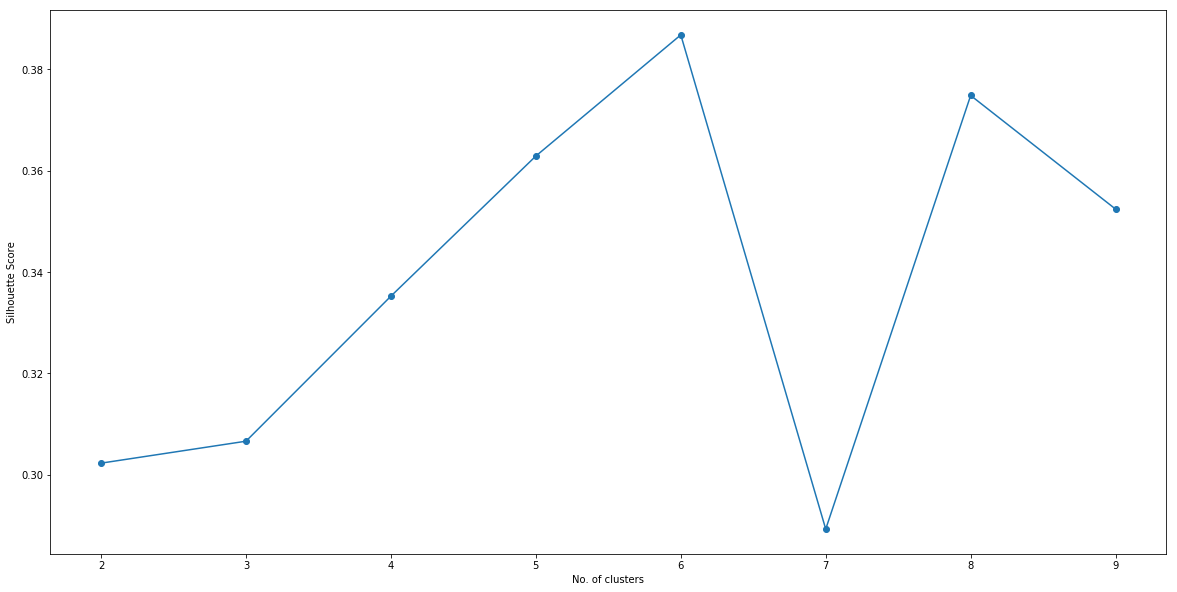

In [35]:
def plot(x, y, xlabel, ylabel):
    plt.figure(figsize=(20,10))
    plt.plot(np.arange(2, x), y, 'o-')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(np.arange(2, x))
    plt.show()
    
indices = []
scores = []
max_range = 10

for kclusters in range(2, max_range) :
    
    # Run k-means clustering
    lct = London_clustering_testing
    kmeans = KMeans(n_clusters = kclusters, init = 'k-means++', random_state = 0).fit_predict(lct)
    
    # Gets the score for the clustering operation performed
    score = silhouette_score(lct, kmeans)
    
    # Appending the index and score to the respective lists
    indices.append(kclusters)
    scores.append(score)
    

plot(max_range, scores, "No. of clusters", "Silhouette Score")

In [36]:
opt = np.argmax(scores) + 2 # Finds the optimal value
opt

6

In [37]:
# set number of clusters
kclusters = opt

London_grouped_clustering = London_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(London_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 3, 1, 2, 4, 4, 2, 1, 4, 4], dtype=int32)

#### Based on the above results a new dataframe would be created to indicates the clusters along with the top 10 venues for each neighborhood.

In [38]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

London_merged = London_restaurants

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
London_merged = London_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
London_merged.fillna(0)
London_merged.head() # check the last columns!

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
9,Acton,51.508140,-0.273261,Amigo's Peri Peri,51.508396,-0.274561,Fast Food Restaurant,0,Fast Food Restaurant,Chinese Restaurant,Xinjiang Restaurant,Himalayan Restaurant,Falafel Restaurant,French Restaurant,Gluten-free Restaurant,Greek Restaurant,Hunan Restaurant,English Restaurant
16,Acton,51.508140,-0.273261,North China Restaurant,51.508251,-0.277435,Chinese Restaurant,0,Fast Food Restaurant,Chinese Restaurant,Xinjiang Restaurant,Himalayan Restaurant,Falafel Restaurant,French Restaurant,Gluten-free Restaurant,Greek Restaurant,Hunan Restaurant,English Restaurant
24,Addington,51.358637,-0.031635,The Cricketers (Harvester),51.357833,-0.032844,English Restaurant,3,English Restaurant,Xinjiang Restaurant,Japanese Restaurant,Japanese Curry Restaurant,Italian Restaurant,Israeli Restaurant,Indonesian Restaurant,Indian Restaurant,Hunan Restaurant,Himalayan Restaurant
32,Addiscombe,51.379692,-0.074282,KFC,51.380105,-0.073570,Fast Food Restaurant,1,Fast Food Restaurant,Chinese Restaurant,Xinjiang Restaurant,Himalayan Restaurant,Falafel Restaurant,French Restaurant,Gluten-free Restaurant,Greek Restaurant,Hunan Restaurant,English Restaurant
34,Addiscombe,51.379692,-0.074282,Brothers,51.379690,-0.074347,Fast Food Restaurant,1,Fast Food Restaurant,Chinese Restaurant,Xinjiang Restaurant,Himalayan Restaurant,Falafel Restaurant,French Restaurant,Gluten-free Restaurant,Greek Restaurant,Hunan Restaurant,English Restaurant


#### Number of venues belonging to each cluster:

In [39]:
London_merged['Cluster Labels'].value_counts()

4    889
2     29
1     27
0     17
5      6
3      3
Name: Cluster Labels, dtype: int64

### Map of clusters:
### The following codes would result in a map being generated to indicate each cluster for better visualization.

In [40]:
# create map
map_clusters = folium.Map(location=[lat_e, long_e], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster, vc in zip(London_merged['Venue Latitude'], London_merged['Venue Longitude'], London_merged['Venue'], London_merged['Cluster Labels'], London_merged['Venue Category']):
    label = folium.Popup(str(poi) +' (' +str(vc) + ') ['+ str(cluster)+']', parse_html=True)

    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
    
map_clusters

### Analysing the clusters

#### Now,  each cluster would be examined and  the discriminating restaurants would be distinguished by each cluster. Based on the restaurants, we can then assign a name to each cluster.

### Cluster 1

In [41]:
c1 = London_merged.loc[London_merged['Cluster Labels'] == 0, London_merged.columns[[0]+list(range(8, London_merged.shape[1]))]]
c1.drop_duplicates()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
9,Acton,Fast Food Restaurant,Chinese Restaurant,Xinjiang Restaurant,Himalayan Restaurant,Falafel Restaurant,French Restaurant,Gluten-free Restaurant,Greek Restaurant,Hunan Restaurant,English Restaurant
373,Arnos Grove,Chinese Restaurant,Xinjiang Restaurant,Himalayan Restaurant,Falafel Restaurant,Fast Food Restaurant,French Restaurant,Gluten-free Restaurant,Greek Restaurant,Hunan Restaurant,English Restaurant
859,Becontree Heath,Chinese Restaurant,Xinjiang Restaurant,Himalayan Restaurant,Falafel Restaurant,Fast Food Restaurant,French Restaurant,Gluten-free Restaurant,Greek Restaurant,Hunan Restaurant,English Restaurant
931,Belmont,Asian Restaurant,Chinese Restaurant,Xinjiang Restaurant,Hunan Restaurant,Fast Food Restaurant,French Restaurant,Gluten-free Restaurant,Greek Restaurant,Himalayan Restaurant,Indian Restaurant
1223,Blackheath Royal Standard,Fast Food Restaurant,Chinese Restaurant,Xinjiang Restaurant,Himalayan Restaurant,Falafel Restaurant,French Restaurant,Gluten-free Restaurant,Greek Restaurant,Hunan Restaurant,English Restaurant
1335,Bow,Turkish Restaurant,Chinese Restaurant,Xinjiang Restaurant,Himalayan Restaurant,Falafel Restaurant,Fast Food Restaurant,French Restaurant,Gluten-free Restaurant,Greek Restaurant,Hunan Restaurant
1543,Brockley,Malay Restaurant,Chinese Restaurant,Xinjiang Restaurant,Hunan Restaurant,Fast Food Restaurant,French Restaurant,Gluten-free Restaurant,Greek Restaurant,Himalayan Restaurant,Indian Restaurant
2759,Colindale,Fast Food Restaurant,Chinese Restaurant,Xinjiang Restaurant,Himalayan Restaurant,Falafel Restaurant,French Restaurant,Gluten-free Restaurant,Greek Restaurant,Hunan Restaurant,English Restaurant
3656,East Barnet,Chinese Restaurant,Xinjiang Restaurant,Himalayan Restaurant,Falafel Restaurant,Fast Food Restaurant,French Restaurant,Gluten-free Restaurant,Greek Restaurant,Hunan Restaurant,English Restaurant
4372,Forest Hill,Chinese Restaurant,Xinjiang Restaurant,Himalayan Restaurant,Falafel Restaurant,Fast Food Restaurant,French Restaurant,Gluten-free Restaurant,Greek Restaurant,Hunan Restaurant,English Restaurant


### Cluster 2

In [42]:
c2 = London_merged.loc[London_merged['Cluster Labels'] == 1, London_merged.columns[[0]+list(range(8, London_merged.shape[1]))]]
c2.drop_duplicates()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
32,Addiscombe,Fast Food Restaurant,Chinese Restaurant,Xinjiang Restaurant,Himalayan Restaurant,Falafel Restaurant,French Restaurant,Gluten-free Restaurant,Greek Restaurant,Hunan Restaurant,English Restaurant
255,Anerley,Fast Food Restaurant,Xinjiang Restaurant,English Restaurant,Japanese Restaurant,Japanese Curry Restaurant,Italian Restaurant,Israeli Restaurant,Indonesian Restaurant,Indian Restaurant,Hunan Restaurant
554,Barking,Fast Food Restaurant,Portuguese Restaurant,Himalayan Restaurant,Ethiopian Restaurant,Falafel Restaurant,French Restaurant,Gluten-free Restaurant,Greek Restaurant,Hunan Restaurant,Korean Restaurant
840,Beckton,Fast Food Restaurant,Xinjiang Restaurant,English Restaurant,Japanese Restaurant,Japanese Curry Restaurant,Italian Restaurant,Israeli Restaurant,Indonesian Restaurant,Indian Restaurant,Hunan Restaurant
850,Becontree,Fast Food Restaurant,Xinjiang Restaurant,English Restaurant,Japanese Restaurant,Japanese Curry Restaurant,Italian Restaurant,Israeli Restaurant,Indonesian Restaurant,Indian Restaurant,Hunan Restaurant
919,Bellingham,Fast Food Restaurant,Turkish Restaurant,Xinjiang Restaurant,Hunan Restaurant,Falafel Restaurant,French Restaurant,Gluten-free Restaurant,Greek Restaurant,Himalayan Restaurant,Indian Restaurant
1434,Brimsdown,Fast Food Restaurant,Xinjiang Restaurant,English Restaurant,Japanese Restaurant,Japanese Curry Restaurant,Italian Restaurant,Israeli Restaurant,Indonesian Restaurant,Indian Restaurant,Hunan Restaurant
1609,Bromley Common,Fast Food Restaurant,Xinjiang Restaurant,English Restaurant,Japanese Restaurant,Japanese Curry Restaurant,Italian Restaurant,Israeli Restaurant,Indonesian Restaurant,Indian Restaurant,Hunan Restaurant
2325,Chelsfield,Fast Food Restaurant,Xinjiang Restaurant,English Restaurant,Japanese Restaurant,Japanese Curry Restaurant,Italian Restaurant,Israeli Restaurant,Indonesian Restaurant,Indian Restaurant,Hunan Restaurant
2768,Collier Row,Fast Food Restaurant,Xinjiang Restaurant,English Restaurant,Japanese Restaurant,Japanese Curry Restaurant,Italian Restaurant,Israeli Restaurant,Indonesian Restaurant,Indian Restaurant,Hunan Restaurant


 ### Cluster 3

In [43]:
c3 = London_merged.loc[London_merged['Cluster Labels'] == 2, London_merged.columns[[0]+list(range(8, London_merged.shape[1]))]]
c3.drop_duplicates()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
42,Albany Park,Indian Restaurant,Xinjiang Restaurant,English Restaurant,Japanese Restaurant,Japanese Curry Restaurant,Italian Restaurant,Israeli Restaurant,Indonesian Restaurant,Hunan Restaurant,Himalayan Restaurant
246,Alperton,Indian Restaurant,Fast Food Restaurant,Asian Restaurant,Hunan Restaurant,Falafel Restaurant,French Restaurant,Gluten-free Restaurant,Greek Restaurant,Himalayan Restaurant,Xinjiang Restaurant
862,Beddington,Indian Restaurant,Xinjiang Restaurant,English Restaurant,Japanese Restaurant,Japanese Curry Restaurant,Italian Restaurant,Israeli Restaurant,Indonesian Restaurant,Hunan Restaurant,Himalayan Restaurant
992,Belvedere,Eastern European Restaurant,Indian Restaurant,English Restaurant,Japanese Restaurant,Japanese Curry Restaurant,Italian Restaurant,Israeli Restaurant,Indonesian Restaurant,Hunan Restaurant,Himalayan Restaurant
1247,Blendon,Indian Restaurant,Xinjiang Restaurant,English Restaurant,Japanese Restaurant,Japanese Curry Restaurant,Italian Restaurant,Israeli Restaurant,Indonesian Restaurant,Hunan Restaurant,Himalayan Restaurant
2077,Chadwell Heath,Indian Restaurant,Fast Food Restaurant,Xinjiang Restaurant,English Restaurant,Japanese Restaurant,Japanese Curry Restaurant,Italian Restaurant,Israeli Restaurant,Indonesian Restaurant,Hunan Restaurant
2452,Chislehurst,Italian Restaurant,Indian Restaurant,Xinjiang Restaurant,English Restaurant,Japanese Restaurant,Japanese Curry Restaurant,Israeli Restaurant,Indonesian Restaurant,Hunan Restaurant,Himalayan Restaurant
2795,Colney Hatch,Eastern European Restaurant,Indian Restaurant,English Restaurant,Japanese Restaurant,Japanese Curry Restaurant,Italian Restaurant,Israeli Restaurant,Indonesian Restaurant,Hunan Restaurant,Himalayan Restaurant
2976,Cranham,Indian Restaurant,Fast Food Restaurant,Xinjiang Restaurant,English Restaurant,Japanese Restaurant,Japanese Curry Restaurant,Italian Restaurant,Israeli Restaurant,Indonesian Restaurant,Hunan Restaurant
3180,Cubitt Town,Indian Restaurant,Xinjiang Restaurant,English Restaurant,Japanese Restaurant,Japanese Curry Restaurant,Italian Restaurant,Israeli Restaurant,Indonesian Restaurant,Hunan Restaurant,Himalayan Restaurant


### Cluster 4

In [44]:
c4 = London_merged.loc[London_merged['Cluster Labels'] == 3, London_merged.columns[[0]+list(range(8, London_merged.shape[1]))]]
c4.drop_duplicates()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
24,Addington,English Restaurant,Xinjiang Restaurant,Japanese Restaurant,Japanese Curry Restaurant,Italian Restaurant,Israeli Restaurant,Indonesian Restaurant,Indian Restaurant,Hunan Restaurant,Himalayan Restaurant
3059,Crook Log,English Restaurant,Xinjiang Restaurant,Japanese Restaurant,Japanese Curry Restaurant,Italian Restaurant,Israeli Restaurant,Indonesian Restaurant,Indian Restaurant,Hunan Restaurant,Himalayan Restaurant
3769,Eden Park,English Restaurant,Xinjiang Restaurant,Japanese Restaurant,Japanese Curry Restaurant,Italian Restaurant,Israeli Restaurant,Indonesian Restaurant,Indian Restaurant,Hunan Restaurant,Himalayan Restaurant


### Cluster 5

In [45]:
c5 = London_merged.loc[London_merged['Cluster Labels'] == 4, London_merged.columns[[0]+list(range(8, London_merged.shape[1]))]]
c5.drop_duplicates()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
52,Aldgate,Middle Eastern Restaurant,Italian Restaurant,Indian Restaurant,Restaurant,Thai Restaurant,Asian Restaurant,Sushi Restaurant,Vietnamese Restaurant,Japanese Restaurant,Mediterranean Restaurant
147,Aldwych,Restaurant,Japanese Restaurant,Sushi Restaurant,English Restaurant,Italian Restaurant,American Restaurant,Argentinian Restaurant,Tapas Restaurant,Lebanese Restaurant,Spanish Restaurant
263,Angel,Mediterranean Restaurant,French Restaurant,Vietnamese Restaurant,Indian Restaurant,Mexican Restaurant,Hunan Restaurant,Ramen Restaurant,Restaurant,Caucasian Restaurant,Afghan Restaurant
329,Archway,Italian Restaurant,Kebab Restaurant,Fast Food Restaurant,Asian Restaurant,Indian Restaurant,Vegetarian / Vegan Restaurant,Japanese Restaurant,Japanese Curry Restaurant,Israeli Restaurant,Indonesian Restaurant
378,Balham,Indian Restaurant,Italian Restaurant,Portuguese Restaurant,Restaurant,Fast Food Restaurant,Moroccan Restaurant,English Restaurant,Indonesian Restaurant,Hunan Restaurant,Himalayan Restaurant
440,Bankside,Italian Restaurant,Portuguese Restaurant,Spanish Restaurant,Modern European Restaurant,Israeli Restaurant,Ramen Restaurant,Restaurant,English Restaurant,Asian Restaurant,Vietnamese Restaurant
495,Barbican,French Restaurant,Italian Restaurant,Moroccan Restaurant,Vietnamese Restaurant,Modern European Restaurant,English Restaurant,Spanish Restaurant,Greek Restaurant,Falafel Restaurant,Fast Food Restaurant
577,Barnehurst,Asian Restaurant,Middle Eastern Restaurant,Xinjiang Restaurant,Hunan Restaurant,Fast Food Restaurant,French Restaurant,Gluten-free Restaurant,Greek Restaurant,Himalayan Restaurant,Indonesian Restaurant
611,Barnet,Restaurant,Italian Restaurant,Fast Food Restaurant,Indian Restaurant,Chinese Restaurant,Xinjiang Restaurant,Greek Restaurant,Falafel Restaurant,French Restaurant,Gluten-free Restaurant
637,Barnsbury,Ethiopian Restaurant,Chinese Restaurant,Caucasian Restaurant,Xinjiang Restaurant,Himalayan Restaurant,Fast Food Restaurant,French Restaurant,Gluten-free Restaurant,Greek Restaurant,Hunan Restaurant


### Cluster 6

In [46]:
c6 = London_merged.loc[London_merged['Cluster Labels'] == 5, London_merged.columns[[0]+list(range(8, London_merged.shape[1]))]]
c6.drop_duplicates()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
584,Barnes,Restaurant,Thai Restaurant,Xinjiang Restaurant,Greek Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,French Restaurant,Gluten-free Restaurant,Himalayan Restaurant
2808,Coney Hall,Restaurant,Xinjiang Restaurant,Himalayan Restaurant,Falafel Restaurant,Fast Food Restaurant,French Restaurant,Gluten-free Restaurant,Greek Restaurant,Hunan Restaurant,English Restaurant
2950,Cowley,Restaurant,Xinjiang Restaurant,Himalayan Restaurant,Falafel Restaurant,Fast Food Restaurant,French Restaurant,Gluten-free Restaurant,Greek Restaurant,Hunan Restaurant,English Restaurant
3471,Dulwich,Restaurant,Xinjiang Restaurant,Himalayan Restaurant,Falafel Restaurant,Fast Food Restaurant,French Restaurant,Gluten-free Restaurant,Greek Restaurant,Hunan Restaurant,English Restaurant
3660,East Bedfont,Restaurant,Xinjiang Restaurant,Himalayan Restaurant,Falafel Restaurant,Fast Food Restaurant,French Restaurant,Gluten-free Restaurant,Greek Restaurant,Hunan Restaurant,English Restaurant


In [48]:
import seaborn as sns

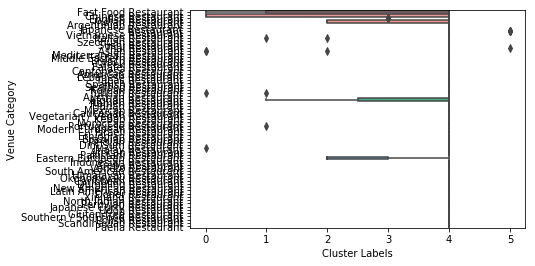

In [49]:
sns.boxplot(London_merged['Cluster Labels'], London_merged['Venue Category'])


### Results

Considering the clustering results we can approach the following:

-	The most commom restaurants in each cluster have been located;
-   The best boroughs to open a restaurant with a specefic cuisine (i.e., most favorite cuisine of the borough) can be choosen;
-   The neighborhood in a specific cluster, can be choosen in order to open a restaurent which is the least common in that specific region, which would result in profitability and less competition; 



   | Cluster | Most Common Restaurant     | 
   |---------|----------------------------|
   |   1     | Chinese Restaurant         | 
   |   2     | Fast Food Restaurant       | 
   |   3     | Indian Restaurant          | 
   |   4     | English Restaurant         | 
   |   5     | Italian Restaurant         |
   |   6     | Xinjiang Restaurant        | 
   

### Conclusion

The presented work has been conducted based on a small sample cluster, for the sole purpose of depicting the program’s feasibility potential. It can further be extended into larger data sets, and as result, the program would result in more output results and findings. The outcomes would also provide the relevant information on the number and intensity of the restaurants in certain boroughs, which can be interpreted as which areas would be of higher demands in terms of the popular regions for the intended cuisine and leisure industry. Moreover, a number of other factors regarding these places can be included in order to distinguish or narrow down the results, such as the restaurants’ type (e.g., Italian, Asian, etc.) or hygiene rate. 

